# Concise Implementation of Softmax Regression
:label:`sec_softmax_concise`

## Section Summary
This section explains how to implement a Softmax Regression model using high-level deep learning frameworks. The fully connected layer is created using the built-in layer and a Flatten layer is used to convert the input tensor to a 2D tensor. To avoid numerical overflow and underflow when applying the Softmax function, the logits are passed to the cross-entropy loss function instead of the Softmax probabilities. The implementation uses Fashion-MNIST images and the model is trained using a Trainer object.



In [13]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

## Defining the Model


In [14]:
class SoftmaxRegression(d2l.Classifier):  #@save
    """The softmax regression model."""
    def __init__(self, num_outputs, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(nn.Flatten(),
                                 nn.LazyLinear(num_outputs))

    def forward(self, X):
        return self.net(X)

In [15]:
@d2l.add_to_class(d2l.Classifier)  #@save
def loss(self, Y_hat, Y, averaged=True):
    Y_hat = Y_hat.reshape((-1, Y_hat.shape[-1]))
    Y = Y.reshape((-1,))
    return F.cross_entropy(
        Y_hat, Y, reduction='mean' if averaged else 'none')

## Training



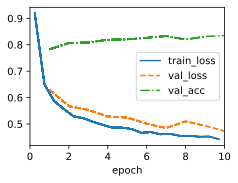

In [16]:
data = d2l.FashionMNIST(batch_size=256)
model = SoftmaxRegression(num_outputs=10, lr=0.1)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

In [26]:
print(model)
sum([param.nelement() for param in model.parameters()])

SoftmaxRegression(
  (net): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
  )
)


7850

In [17]:
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms

test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=
                                               transforms.Compose([transforms.ToTensor()]))  

test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=100)

def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

class_correct = [0. for _ in range(10)]
total_correct = [0. for _ in range(10)]
predictions_list = []
labels_list = []

with torch.no_grad():
    for images, labels in test_loader:
        labels_list.append(labels)
        test = Variable(images)
        outputs = model(test)
        predicted = torch.max(outputs, 1)[1]
        predictions_list.append(predicted)
        c = (predicted == labels).squeeze()
        
        for i in range(100):
            label = labels[i]
            class_correct[label] += c[i].item()
            total_correct[label] += 1
        
for i in range(10):
    print("Accuracy of {}: {:.2f}%".format(output_label(i), class_correct[i] * 100 / total_correct[i]))


Accuracy of T-shirt/Top: 78.10%
Accuracy of Trouser: 94.60%
Accuracy of Pullover: 69.70%
Accuracy of Dress: 86.70%
Accuracy of Coat: 76.10%
Accuracy of Sandal: 90.40%
Accuracy of Shirt: 58.60%
Accuracy of Sneaker: 89.90%
Accuracy of Bag: 93.90%
Accuracy of Ankle Boot: 95.70%


In [18]:
from itertools import chain 

predictions_l = [predictions_list[i].tolist() for i in range(len(predictions_list))]
labels_l = [labels_list[i].tolist() for i in range(len(labels_list))]
predictions_l = list(chain.from_iterable(predictions_l))
labels_l = list(chain.from_iterable(labels_l))


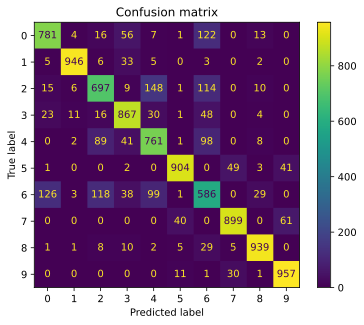

Classification report for LinearClassification :
              precision    recall  f1-score   support

           0       0.82      0.78      0.80      1000
           1       0.97      0.95      0.96      1000
           2       0.73      0.70      0.71      1000
           3       0.82      0.87      0.84      1000
           4       0.72      0.76      0.74      1000
           5       0.94      0.90      0.92      1000
           6       0.59      0.59      0.59      1000
           7       0.91      0.90      0.91      1000
           8       0.93      0.94      0.93      1000
           9       0.90      0.96      0.93      1000

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000




In [23]:
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

confusion_matrix(labels_l, predictions_l)

disp = ConfusionMatrixDisplay.from_predictions(
      y_pred=predictions_l,
      y_true=labels_l
)
disp.ax_.set_title("Confusion Matrix")

plt.show()

print("Classification report for LinearClassification:\n%s\n"
      % (metrics.classification_report(labels_l, predictions_l)))





## Exercises

1. Deep learning uses many different number formats, including FP64 double precision (used extremely rarely),
FP32 single precision, BFLOAT16 (good for compressed representations), FP16 (very unstable), TF32 (a new format from NVIDIA), and INT8. Compute the smallest and largest argument of the exponential function for which the result does not lead to a numerical underflow or overflow.
1. INT8 is a very limited format with nonzero numbers from $1$ to $255$. How could you extend its dynamic range without using more bits? Do standard multiplication and addition still work?
    - Multiply each value by the constant, which acts as a scaling factor for the inputs. 
1. Increase the number of epochs for training. Why might the validation accuracy decrease after a while? How could we fix this?
    - Overfitting happens, model becoming to specialised to the input data. 
1. What happens as you increase the learning rate? Compare the loss curves for several learning rates. Which one works better? When?
    - Large increase in the learning rate could lead to model not converging to the local minimum.
